reference states: 
array index   /   Fock state   /   integer repr. 
     0.         |2 0>           6  
     1.         |1 1>           4  
     2.         |0 2>           2  
reference states: 
array index   /   Fock state   /   integer repr. 
     0.         |1 0 0>           4  
     1.         |0 1 0>           2  
     2.         |0 0 1>           1  
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
H-space size: 9, initial state: |20>|100>


C:\Users\pavka\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\pavka\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


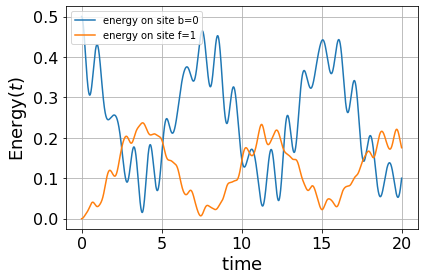

In [22]:
from __future__ import print_function, division
import sys,os
# line 4 and line 5 below are for development purposes and can be removed
qspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,qspin_path)
########################################################################
#                            example 10                                #
#   In this script we demonstrate how to use QuSpin's                  #	
#   tensor basis class to build Hamiltonians for mixtures of different #
#   species. We use this to study the non-equilibrium dynamics         #
#   in a Bose-Fermi mixture. The example also shows how to compute     #
#   the entanglement entropy shared between the species.               #
########################################################################
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import tensor_basis,spinless_fermion_basis_1d,boson_basis_1d # bases
from quspin.tools.measurements import obs_vs_time # calculating dynamics
from quspin.tools.Floquet import Floquet_t_vec # period-spaced time vector
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
#
##### setting up parameters for simulation
# physical parameters
L_f = 3 # system size f
L_b = L_f-1 # system size b
Nf, Nb = L_f-2, 2 # number of fermions, bosons
N = Nf + Nb # total number of particles
Jb, Jf = 1.0, 1.0 # boson, fermon hopping strength
Uff, Ubb, Ubf = 0.5, 0.5, 5.0  # bb, ff, bf interaction
mu_b, mu_f = -0.5, -0.5 # b, f chemical potential 
# define time-dependent perturbation
A = 0
Omega = 1.0
def drive(t,Omega):
	return np.sin(Omega*t)
drive_args=[Omega]
#
###### create the basis
# build the two bases to tensor together to a bose-fermi mixture
basis_b=boson_basis_1d(L_b,Nb=Nb) # boson basis
basis_f=spinless_fermion_basis_1d(L_f,Nf=Nf) # fermion basis
basis=tensor_basis(basis_b,basis_f) # BFM
#
print(basis_b)
print(basis_f)
##### create model
# define site-coupling lists
hop_b = [[-Jb,i,(i+1)%L_b] for i in range(L_b)] # b hopping
int_list_bb = [[Ubb/2.0,i,i] for i in range(L_b)] # bb onsite interaction
int_list_bb_lin = [[-Ubb/2.0,i] for i in range(L_b)] # bb interaction, linear term
# 
hop_f_right = [[-Jf,i,(i+1)%L_f] for i in range(L_f)] # f hopping right
hop_f_left = [[Jf,i,(i+1)%L_f] for i in range(L_f)] # f hopping left
int_list_ff = [[Uff,i,(i+1)%L_f] for i in range(L_f)] # ff nearest-neighbour interaction
drive_f = [[A*(-1.0)**i,i] for i in range(L_f)] # density staggered drive
#
chem_f = [[mu_f,i] for i in range(L_f)] #chemical potential for fermions
chem_b = [[mu_b,i] for i in range(L_b)] #chemical potential for bosons
#
int_list_bf = [[Ubf,i,i] for i in range(L_b)] # bf onsite interaction
# create resource Hamiltonian
static = [	
			["+-|", hop_b], # bosons hop left
			["-+|", hop_b], # bosons hop right
			["n|", int_list_bb_lin], # bb onsite interaction
			["nn|", int_list_bb], # bb onsite interaction
			#
			["|+-", hop_f_left], # fermions hop left
			["|-+", hop_f_right], # fermions hop right
			["|nn", int_list_ff], # ff nn interaction
			#
			["n|n", int_list_bf], # bf onsite interaction
            #
            [
             "|n", chem_f], #chemical potential fermions
            [
             "n|", chem_b],  #chemical potential bosons    
			]
dynamic = [["|n",drive_f,drive,drive_args]] # drive couples to fermions only
############################################## target hamiltonian b
int_list_bb_target = [[Ubb/2.0,0]] # bb onsite interaction target
#int_list_bb_lin_target = [[-Ubb/2.0,1]] # bb interaction, linear term target

#
static_target = [
                ["n|", int_list_bb_target], # bb onsite interaction target
#			["n|", int_list_bb_lin_target], # bb onsite interaction

]
################################################


############################################## target hamiltonian f
int_list_ff_target_f = [[Uff/2.0,1]] # bb onsite interaction target
#int_list_bb_lin_target = [[-Ubb/2.0,1]] # bb interaction, linear term target

#
static_target_f = [
                ["|n", int_list_ff_target_f], # bb onsite interaction target
#			["n|", int_list_bb_lin_target], # bb onsite interaction

]
################################################
###### set up Hamiltonian and initial states
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_BFM = hamiltonian(static,dynamic,basis=basis,**no_checks)
H_target = hamiltonian(static_target,dynamic,basis=basis,**no_checks)
H_target_f = hamiltonian(static_target_f,dynamic,basis=basis,**no_checks)

# define initial Fock state through strings
s_f = "".join("1") + "".join("0") + "".join("0")
s_b = "".join("2") + "".join("0")
# basis.index accepts strings and returns the index which corresponds to that state in the basis list
i_0 = basis.index(s_b,s_f) # find index of product state in basis
psi_0 = np.zeros(basis.Ns) # allocate space for state
psi_0[i_0] = 1.0 # set MB state to be the given product state
print("H-space size: {:d}, initial state: |{:s}>|{:s}>".format(basis.Ns,s_b,s_f))
#
###### time evolve initial state and measure energy
times=np.linspace(0.0,20.0,10000)
psi_t = H_BFM.evolve(psi_0,0.0,times)
# measure observable
observables_dict = dict(E_target = H_target, E_target_f = H_target_f)

meas = obs_vs_time(psi_t,times,observables_dict)
# read off measurements
E_target_time = meas['E_target']
E_target_f_time = meas['E_target_f']

#
######
# configuring plots
plt.plot(times, E_target_time, label='energy on site b=0')
plt.plot(times, E_target_f_time, label='energy on site f=1')

plt.xlabel("$\\mathrm{time}$",fontsize=18)
plt.ylabel('$\mathrm{Energy}(t)$',fontsize=18)
plt.grid(True)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.legend()
#plt.savefig('Energy_BFM.pdf', bbox_inches='tight')
plt.show()
plt.close()


In [10]:
from __future__ import print_function, division
import sys,os
# line 4 and line 5 below are for development purposes and can be removed
qspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,qspin_path)

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import tensor_basis,spinful_fermion_basis_1d,boson_basis_1d # bases
from quspin.tools.measurements import obs_vs_time # calculating dynamics
from quspin.tools.Floquet import Floquet_t_vec # period-spaced time vector
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
#
##### setting up parameters for simulation
# physical parameters
l = 1
L_f = 3 # system size f
L_b = L_f-1 # system size b
Nf, Nb = 2, l # number of fermions, bosons
N = Nf + Nb # total number of particles
tb, tf = 0.001, 0.001 # boson, fermon hopping strength
U = 1.0  # n(n-1) interaction strength
V = 1.0
mu_b, mu_f = -0.5, -0.5 # b, f chemical potential 
# define time-dependent perturbation
A = 0
Omega = 1.0
def drive(t,Omega):
    return np.sin(Omega*t)
drive_args=[Omega]
#
###### create the basis
# build the two bases to tensor together to a bose-fermi mixture
basis_b1=boson_basis_1d(L_b,Nb=[i for i in range(2*l*L_b+1)],sps=2*l+1) # boson basis
basis_b2=boson_basis_1d(L_b,Nb=[i for i in range(2*l*L_b+1)],sps=2*l+1) # boson basis
basis_f=spinful_fermion_basis_1d(L_f,Nf = [(0,0),(0,1),(1,0),(1,1),(2,0),(0,2),(1,2),(2,1),(2,2),(0,3),(3,0),(3,1),(1,3),(2,3),(3,2),(3,3)],double_occupancy=True)
basis=tensor_basis(basis_b1,basis_b2,basis_f) # BFM
#
#print(basis_b1)
#print(basis_f)
##### create model
# define site-coupling lists
hop_b = [[-tb,i,(i+1)] for i in range(L_b-1)] # b hopping
int_list_bb = [[U/2.0,i,i] for i in range(L_b)] # bb onsite interaction
int_list_bb_lin = [[-U/2.0,i] for i in range(L_b)] # bb interaction, linear term
# 
hop_f_right = [[-tf,i,(i+1)] for i in range(L_f-1)] # f hopping right
hop_f_left = [[tf,i,(i+1)] for i in range(L_f-1)] # f hopping left
drive_f = [[A*(-1.0)**i,i] for i in range(L_f)] # density staggered drive
#
chem_f = [[mu_f,i] for i in range(L_f)] #chemical potential for fermions
chem_b = [[mu_b,i] for i in range(L_b)] #chemical potential for bosons
#
int_list_bf = [[V,i,j] for i in range(L_b) for j in range(L_f)] # bf onsite interaction
#int_list_bf_offsite = [[V,i,i+1] for i in range(L_b)] # bf onsite interaction

# create resource Hamiltonian
bosons_hopping = [	
            ["+-|||", hop_b], # bosons hop left
            ["|+-||", hop_b], # bosons hop left

            ["-+|||", hop_b], # bosons hop right
            ["|-+||", hop_b], # bosons hop right
]

bosons_on_site_int = [
            ["n|||", int_list_bb_lin], # bb onsite interaction
            ["|n||", int_list_bb_lin], # bb onsite interaction

            ["nn|||", int_list_bb], # bb onsite interaction
            ["|nn||", int_list_bb], # bb onsite interaction
]
            #
fermions_hopping = [
            ["|||+-", hop_f_left], # fermions hop left
            ["||+-|", hop_f_left], # fermions hop left

            ["|||-+", hop_f_right], # fermions hop right
            ["||-+|", hop_f_right], # fermions hop right
]
            #
boson_fermion_int = [
            ["n|||n", int_list_bf], # bf onsite interaction
            ["n||n|", int_list_bf], # bf onsite interaction
            ["|n|n|", int_list_bf], # bf onsite interaction
            ["|n||n", int_list_bf], # bf onsite interaction
]

            #
chem_potential_f = [
            ["|||n", chem_f], #chemical potential fermions
            ["||n|", chem_f], #chemical potential fermions
]
chem_potential_b = [
            ["n|||", chem_b],  #chemical potential bosons 
            ["|n||", chem_b],  #chemical potential bosons    

            ]
dynamic = [["|n",drive_f,drive,drive_args]] # drive couples to fermions only

############################################## target  hamiltonian
a = 0.1
e = 1.0
m = 1.0

bosonic_part_LGT = [[a*e**2/4.,i,i,i,i] for i in range(L_b)] # b^dagger*b^dagger*b*b
mass_f = [[m+1.0/a,i,i] for i in range(L_f)] # f mass term
m_mass_f = [[-m-1.0/a,i,i] for i in range(L_f)] # f mass term

interaction_part_LGT = [[1.0/(a*np.sqrt(l*(l+1))),i,i,i,i+1] for i in range(L_b)] #boson-fermion interaction
m_interaction_part_LGT = [[-1.0/(a*np.sqrt(l*(l+1))),i,i,i,i+1] for i in range(L_b)] #boson-fermion interaction



#
static_target = [
            ["++--|||", bosonic_part_LGT], # b^dagger*b^dagger*b*b
            ["|++--||", bosonic_part_LGT], # b^dagger*b^dagger*b*b

            ["||+|-", mass_f], # f mass term
            ["||-|+", m_mass_f], # f mass term


            ["+|-|+|-", interaction_part_LGT], #boson-fermion interaction
            ["-|+|-|+", m_interaction_part_LGT], #boson-fermion interaction


]

b_0 = [[-0.5*e,0]]
d_0 = [[+0.5*e,0]]
b_1 = [[+0.5*e,1]]
d_1 = [[-0.5*e,1]]
rho_1 = [[-e,1]]
eee = [[e,1]]

static_gauss_law = [
    
    ["n|||", b_0],
    ["|n||", d_0],
    ["n|||", b_1],
    ["|n||", d_1],
    ["||n|", rho_1],
    ["|||n", rho_1],
    ["|I||", eee]

]    




################################################
###### set up Hamiltonian and initial states
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_R1  = hamiltonian(bosons_hopping,dynamic,basis=basis,**no_checks)
H_R2  = hamiltonian(bosons_on_site_int,dynamic,basis=basis,**no_checks)
H_R3  = hamiltonian(fermions_hopping,dynamic,basis=basis,**no_checks)
H_R4  = hamiltonian(boson_fermion_int,dynamic,basis=basis,**no_checks)
H_R5  = hamiltonian(chem_potential_f,dynamic,basis=basis,**no_checks)
H_R6  = hamiltonian(chem_potential_b,dynamic,basis=basis,**no_checks)


Gauss_law = hamiltonian(static_gauss_law, dynamic_list = [], basis=basis, **no_checks)




#H_BFM = hamiltonian(static,dynamic,basis=basis,**no_checks)
H_target = hamiltonian(static_target,dynamic,basis=basis,**no_checks)






In [11]:
# define initial Fock state through strings
s_f = ["111","110","101","011","100","010","001","000"]
s_b = ["20","11","10","02","01","00"]
# basis.index accepts strings and returns the index which corresponds to that state in the basis list
i = np.zeros(8)
i[0] = basis.index(s_b[2],s_b[2],s_f[0],s_f[7]) # find index of product state in basis
i[1] = basis.index(s_b[2],s_b[2],s_f[1],s_f[6])
i[2] = basis.index(s_b[2],s_b[2],s_f[2],s_f[5])
i[3] = basis.index(s_b[2],s_b[2],s_f[3],s_f[4])
i[4] = basis.index(s_b[2],s_b[2],s_f[4],s_f[3])
i[5] = basis.index(s_b[2],s_b[2],s_f[5],s_f[2])
i[6] = basis.index(s_b[2],s_b[2],s_f[6],s_f[1])
i[7] = basis.index(s_b[2],s_b[2],s_f[7],s_f[0])


psi_0 = np.zeros(basis.Ns) # allocate space for state
psi_0[int(i[0])] = 1/(np.sqrt(2)**3) # set MB state to be the given product state
psi_0[int(i[1])] = -1/(np.sqrt(2)**3)
psi_0[int(i[2])] = -1/(np.sqrt(2)**3)
psi_0[int(i[3])] = -1/(np.sqrt(2)**3)
psi_0[int(i[4])] = 1/(np.sqrt(2)**3)
psi_0[int(i[5])] = 1/(np.sqrt(2)**3)
psi_0[int(i[6])] = 1/(np.sqrt(2)**3)
psi_0[int(i[7])] = -1/(np.sqrt(2)**3)

In [16]:
#
###### time evolve initial state and measure energy

def extract_energy(theta):
    times1=np.linspace(0.0,theta[0],100)
    times2=np.linspace(0.0,theta[1],100)
    times3=np.linspace(0.0,theta[2],100)
    times4=np.linspace(0.0,theta[3],100)
    times5=np.linspace(0.0,theta[4],100)
    times6=np.linspace(0.0,theta[5],100)


    psi_t1 = H_R1.evolve(psi_0,0.0,times1)
    psi_t2 = H_R2.evolve([row[-1] for row in psi_t1],0.0,times2)
    psi_t3 = H_R3.evolve([row[-1] for row in psi_t2],0.0,times3)
    psi_t4 = H_R4.evolve([row[-1] for row in psi_t3],0.0,times4)
    psi_t5 = H_R5.evolve([row[-1] for row in psi_t4],0.0,times5)
    psi_t6 = H_R6.evolve([row[-1] for row in psi_t5],0.0,times6)



    cost_function = H_target.expt_value([row[-1] for row in psi_t6]) + Gauss_law.expt_value([row[-1] for row in psi_t6])**2
    return np.real(cost_function)


In [17]:
import datetime

print(datetime.datetime.now())
extract_energy(np.array([10.,10.,10.,10.,10.,10.]))
print(datetime.datetime.now())

2021-10-22 15:29:45.404597
2021-10-22 15:29:46.533273


In [18]:
from scipy.optimize import brute
from scipy.optimize import minimize


brute_ranges = (slice(0,10.,1.),slice(0,10.,1.),slice(0,10.,1.),slice(0,10.,1.),slice(0,10.,1.),slice(0,10.,1.))
print(datetime.datetime.now())

resbrute = brute(extract_energy, brute_ranges,full_output = True ,finish = minimize)
print(datetime.datetime.now())


2021-10-22 15:29:51.104893


KeyboardInterrupt: 

In [ ]:
'''''''''''
    # measure observable
    observables_dict = dict(E_target = H_target)

    meas = obs_vs_time(psi_t5,times5,observables_dict)
    # read off measurements
    E_target_time = meas['E_target']    
    return np.real(E_target_time[-1])
'''''''''''

C:\Users\pavka\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


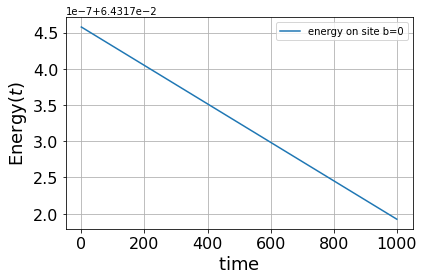

In [18]:
# configuring plots
plt.plot(times5, E_target_time, label='energy on site b=0')

plt.xlabel("$\\mathrm{time}$",fontsize=18)
plt.ylabel('$\mathrm{Energy}(t)$',fontsize=18)
plt.grid(True)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.legend()
#plt.savefig('Energy_BFM.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [11]:
H_target.__init__(static_target, dynamic_list = [],basis=basis, check_herm = True)
#for checking the Hermiticity of the operators
print('target')

Hermiticity check passed!
target


C:\Users\pavka\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_symm=False in hamiltonian
  """Entry point for launching an IPython kernel.
C:\Users\pavka\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  """Entry point for launching an IPython kernel.
